In [2]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: ultralytics in c:\users\vivek\appdata\local\programs\python\python310\lib\site-packages (8.3.68)



You should consider upgrading via the 'c:\Users\Vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="eiESuKS5Yz7zKQnhnycT")
project = rf.workspace("viveks-dan").project("dataset-for-detecting-obstacles-on-railways-dogeu")
version = project.version(2)
dataset = version.download("yolov11")


You should consider upgrading via the 'C:\Users\Vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dataset-for-Detecting-Obstacles-on-Railways-2 in yolov11:: 100%|██████████| 3372/3372 [00:02<00:00, 1409.09it/s]


In [4]:
print("helo")

helo


In [12]:
!yolo detect train data=E:/exceed_2/Dataset-for-Detecting-Obstacles-on-Railways-2/data.yaml model=yolo11s.pt epochs=100 imgsz=64


Ultralytics 8.3.68 🚀 Python-3.10.0 torch-2.5.1+cpu CPU (AMD Ryzen 7 7840HS w/ Radeon 780M Graphics)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=E:/exceed_2/Dataset-for-Detecting-Obstacles-on-Railways-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa


train: Scanning E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\train\labels.cache... 1470 images, 180 backgrounds, 0 corrupt: 100%|██████████| 1470/1470 [00:00<?, ?it/s]
train: Scanning E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\train\labels.cache... 1470 images, 180 backgrounds, 0 corrupt: 100%|██████████| 1470/1470 [00:00<?, ?it/s]

val: Scanning E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\valid\labels.cache... 105 images, 15 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
val: Scanning E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\valid\labels.cache... 105 images, 15 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]
      1/100         0G      5.381      4.839      2.075        106         64:   0%|          | 0/92 [00:00<?, ?it/s]
      1/100         0G      5.381      4.839      2.075        106         64:   1%|          | 1/92 [00:00<01:00,  1.50it/s]
  

In [20]:
import cv2
import numpy as np
from ultralytics import YOLO
import os

# Known parameters
KNOWN_WIDTH = {
    'Animal': 100,  # Average width in cm
    'Car': 180,
    'Person': 45,
    'Rock': 50,
    'Trash': 40
}

def calibrate_focal_length(known_distance, known_width, width_in_pixels):
    return (width_in_pixels * known_distance) / known_width

def calculate_distance(focal_length, real_width, width_in_pixels):
    return (real_width * focal_length) / width_in_pixels

# Load your trained model
model = YOLO('runs/detect/train/weights/best.pt')

calibration_image_path = 'E:/exceed_2/Dataset-for-Detecting-Obstacles-on-Railways-2/test/images/Human-Obstacle-45-_jpg.rf.172a06fcceb8c2ddf053007482dad5ca.jpg' # Replace with your calibration image path
CALIBRATION_DISTANCE = 500  # cm
calibration_class = 'Person'

# Calibrate focal length
calibration_image = cv2.imread(calibration_image_path)
focal_length = None

results = model(calibration_image)
for r in results:
    boxes = r.boxes
    for box in boxes:
        cls = int(box.cls[0])
        class_name = model.names[cls]
        if class_name == calibration_class:
            x1, y1, x2, y2 = box.xyxy[0]
            width_in_pixels = x2 - x1
            focal_length = calibrate_focal_length(
                CALIBRATION_DISTANCE,
                KNOWN_WIDTH[calibration_class],
                width_in_pixels
            )
            break

image_directory = 'E:/exceed_2/Dataset-for-Detecting-Obstacles-on-Railways-2/test/images/'

# Output directory (where processed images will be saved)
output_directory = 'E:/exceed_2/Dataset-for-Detecting-Obstacles-on-Railways-2/output_images/'

# Create output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Process each image in the directory
for image_file in os.listdir(image_directory):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Read image
        image_path = os.path.join(image_directory, image_file)
        frame = cv2.imread(image_path)
        
        results = model(frame)
        
        for r in results:
            boxes = r.boxes
            for box in boxes:
                # Get detection info
                x1, y1, x2, y2 = box.xyxy[0]
                cls = int(box.cls[0])
                class_name = model.names[cls]
                conf = box.conf[0]
                
                # Calculate width in pixels and distance
                width_in_pixels = x2 - x1
                if class_name in KNOWN_WIDTH:
                    distance = calculate_distance(
                        focal_length,
                        KNOWN_WIDTH[class_name],
                        width_in_pixels
                    )
                    
                    # Draw bounding box and label with distance
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    label = f"{class_name}: {distance:.2f}cm"
                    cv2.putText(frame, label, (int(x1), int(y1-10)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    
                    # Warning for close objects
                    if distance < 1000:  # 10 meters
                        warning = "WARNING: Object too close!"
                        cv2.putText(frame, warning, (10, 30), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Save the processed image
        output_path = os.path.join(output_directory, f'processed_{image_file}')
        cv2.imwrite(output_path, frame)
        
        # Display the image (optional)
        cv2.imshow("Processed Image",frame)
        cv2.waitKey(0)  # Wait for key press

cv2.destroyAllWindows()



0: 64x64 2 Trees, 17.9ms
Speed: 1.6ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 (no detections), 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [51]:
print("hello")

hello



0: 64x64 3 Persons, 23.3ms
Speed: 0.0ms preprocess, 23.3ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)
Calibration class 'Person' detected with width in pixels: 90.00094604492188
Calculated focal length: 1600.016845703125

0: 64x64 (no detections), 24.1ms
Speed: 0.0ms preprocess, 24.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


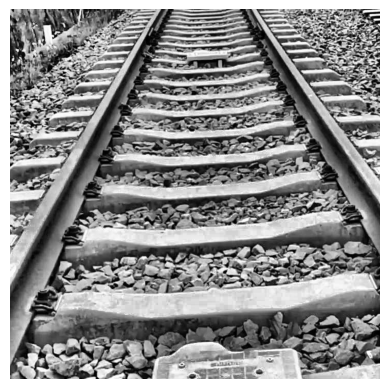


0: 64x64 (no detections), 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


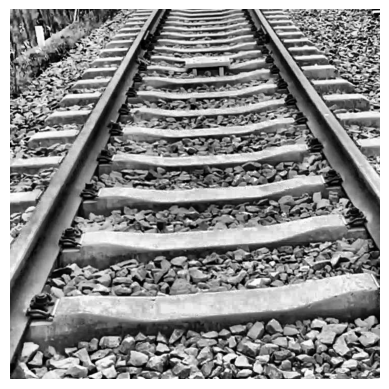


0: 64x64 (no detections), 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


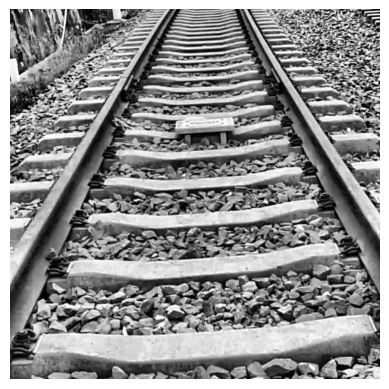


0: 64x64 (no detections), 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 11.0ms postprocess per image at shape (1, 3, 64, 64)


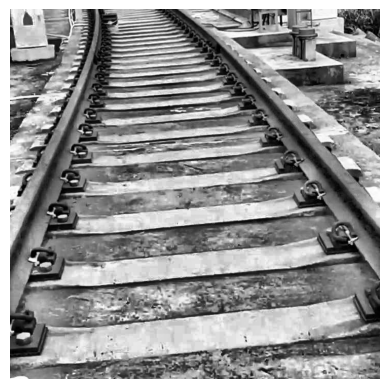


0: 64x64 1 Trash, 19.3ms
Speed: 0.0ms preprocess, 19.3ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)


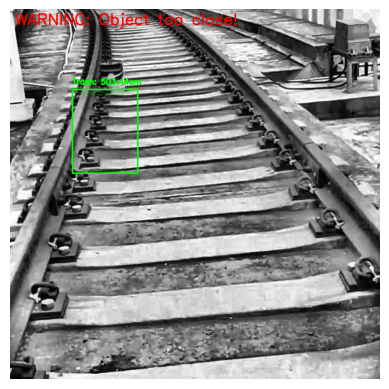


0: 64x64 (no detections), 0.0ms
Speed: 0.5ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


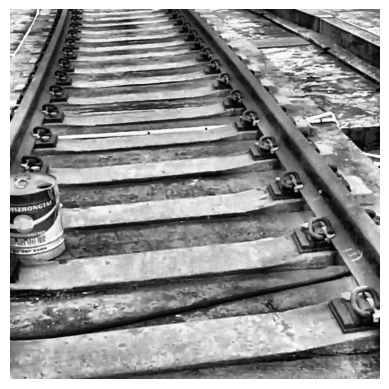


0: 64x64 (no detections), 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


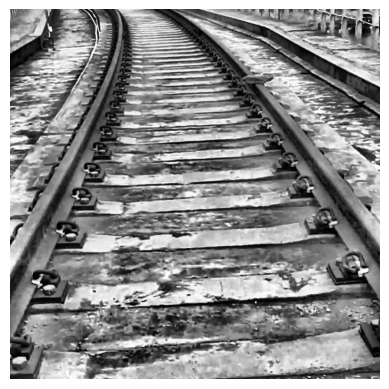


0: 64x64 (no detections), 16.9ms
Speed: 0.0ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


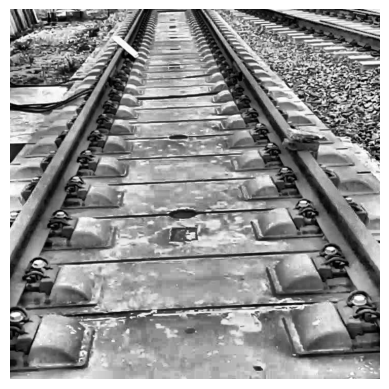


0: 64x64 1 Trash, 12.7ms
Speed: 1.0ms preprocess, 12.7ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


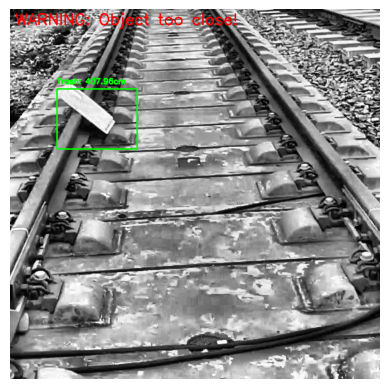


0: 64x64 (no detections), 5.5ms
Speed: 7.5ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


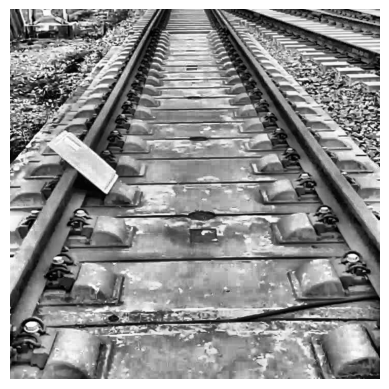


0: 64x64 (no detections), 10.7ms
Speed: 9.5ms preprocess, 10.7ms inference, 4.0ms postprocess per image at shape (1, 3, 64, 64)


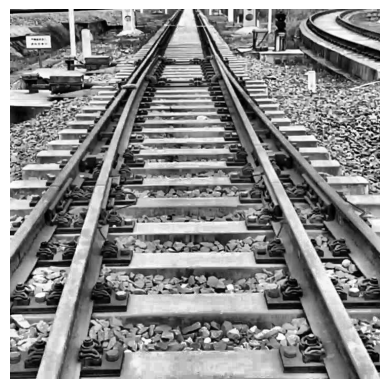


0: 64x64 (no detections), 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


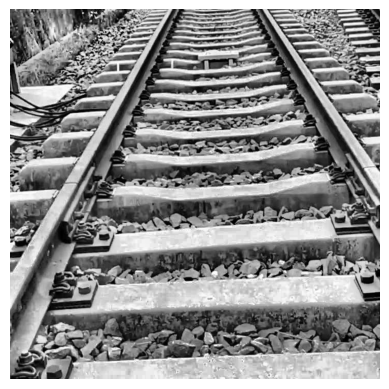


0: 64x64 (no detections), 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


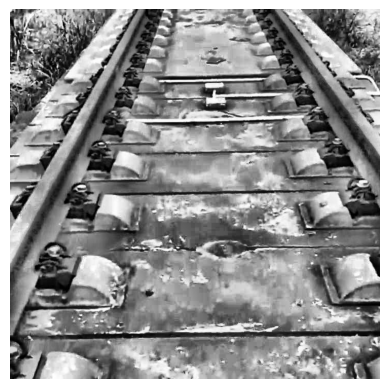


0: 64x64 (no detections), 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


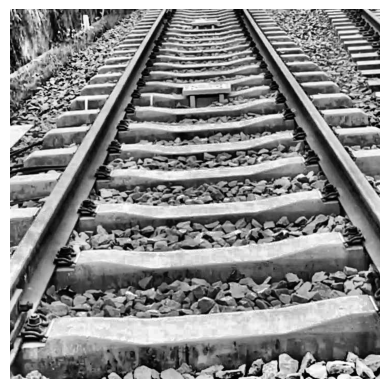


0: 64x64 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


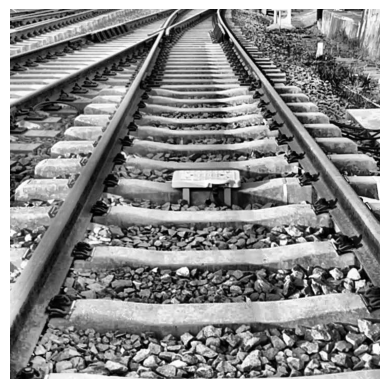


0: 64x64 (no detections), 21.0ms
Speed: 0.0ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


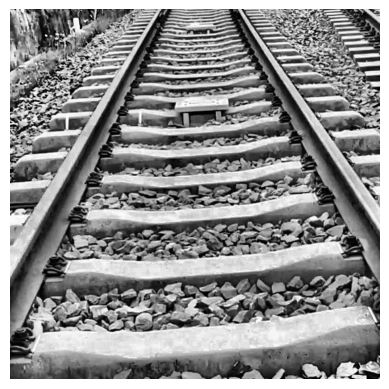


0: 64x64 4 Animals, 1 Person, 19.4ms
Speed: 0.0ms preprocess, 19.4ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


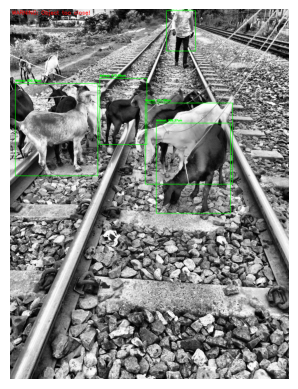


0: 64x64 5 Animals, 3 Persons, 13.8ms
Speed: 0.0ms preprocess, 13.8ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


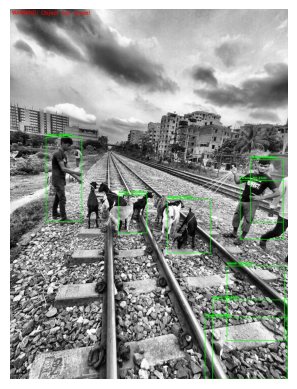


0: 64x64 1 Animal, 2 Persons, 1 Tree, 14.4ms
Speed: 0.0ms preprocess, 14.4ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


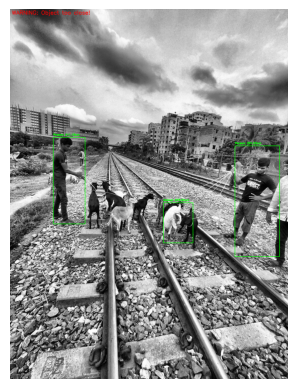


0: 64x64 3 Animals, 3 Persons, 1 Tree, 76.4ms
Speed: 0.0ms preprocess, 76.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


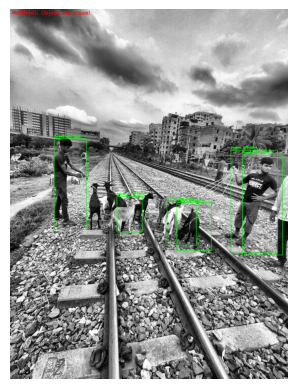


0: 64x64 4 Animals, 2 Persons, 16.6ms
Speed: 0.0ms preprocess, 16.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


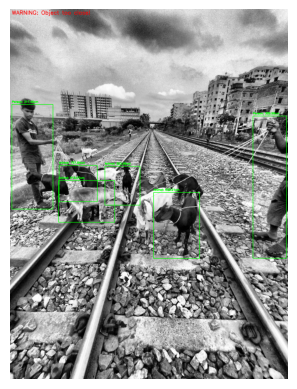


0: 64x64 7 Animals, 2 Trees, 87.4ms
Speed: 0.0ms preprocess, 87.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


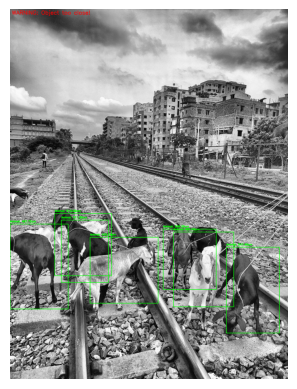


0: 64x64 5 Animals, 2 Persons, 13.2ms
Speed: 0.0ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


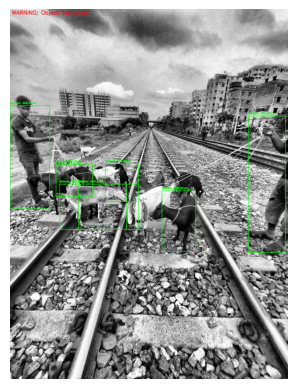


0: 64x64 8 Animals, 2 Trees, 66.1ms
Speed: 1.0ms preprocess, 66.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 64)


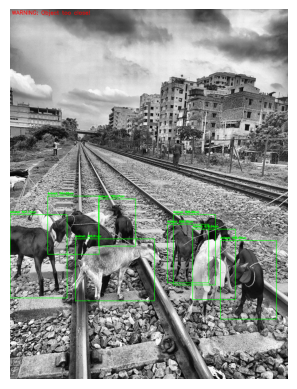


0: 64x64 10 Animals, 2 Trees, 26.6ms
Speed: 0.0ms preprocess, 26.6ms inference, 4.7ms postprocess per image at shape (1, 3, 64, 64)


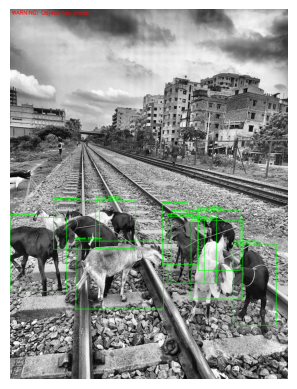

In [50]:
#distance detection :
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

# Known parameters for real-world object widths (in cm)
KNOWN_WIDTH = {
    'Animal': 100,
    'Car': 180,
    'Person': 45,
    'Rock': 50,
    'Trash': 40
}

def calibrate_focal_length(known_distance, real_width, width_in_pixels):
    """Calibrate the focal length of the camera."""
    return (width_in_pixels * known_distance) / real_width

def calculate_distance(focal_length, real_width, width_in_pixels):
    """Calculate the distance from the camera to the object."""
    return (real_width * focal_length) / width_in_pixels

# Load your trained model
model = YOLO('runs/detect/train/weights/best.pt')

# Calibration image path
calibration_image_path = r'E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\train\images\abnormal-319-_jpg.rf.3f1555f62b0e3ab674bf3f6d7961a5da.jpg'
CALIBRATION_DISTANCE = 800 # known distance in cm
calibration_class = 'Person'

# Calibrate focal length
calibration_image = cv2.imread(calibration_image_path)
focal_length = None

results = model(calibration_image)
detected = False

for r in results:
    boxes = r.boxes
    for box in boxes:
        cls = int(box.cls[0])
        class_name = model.names[cls]
        if class_name == calibration_class:
            x1, y1, x2, y2 = box.xyxy[0]
            width_in_pixels = x2 - x1
            focal_length = calibrate_focal_length(
                CALIBRATION_DISTANCE,
                KNOWN_WIDTH[calibration_class],
                width_in_pixels
            )
            detected = True
            print(f"Calibration class '{calibration_class}' detected with width in pixels: {width_in_pixels}")
            print(f"Calculated focal length: {focal_length}")
            break

if not detected:
    print("Calibration failed: Object not detected or no calibration class in image.")
    raise ValueError("Focal length could not be determined. Check the calibration image and class.")

# Directory containing test images
image_directory = r'E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\valid\images'
output_directory = r'path_to_output'  # Replace with your output directory path

# Create output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Process only the first 25 images
image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:25]

for image_file in image_files:
    # Read image
    image_path = os.path.join(image_directory, image_file)
    frame = cv2.imread(image_path)

    results = model(frame)

    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Get detection info
            x1, y1, x2, y2 = box.xyxy[0]
            cls = int(box.cls[0])
            class_name = model.names[cls]
            conf = box.conf[0]

            # Calculate width in pixels and distance
            width_in_pixels = x2 - x1
            if class_name in KNOWN_WIDTH:
                distance = calculate_distance(
                    focal_length,
                    KNOWN_WIDTH[class_name],
                    width_in_pixels
                )

                # Draw bounding box and label with distance
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                label = f"{class_name}: {distance:.2f}cm"
                cv2.putText(frame, label, (int(x1), int(y1-10)),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Warning for close objects
                if distance < 1000:  # 10 meters
                    warning = "WARNING: Object too close!"
                    cv2.putText(frame, warning, (10, 30),
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Save the processed image
    output_path = os.path.join(output_directory, f'processed_{image_file}')
    cv2.imwrite(output_path, frame)

    # Display the image using Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [28]:
pip install --upgrade opencv-python


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Vivek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [40]:
#video

import cv2
import numpy as np
from ultralytics import YOLO
import os

# Known object widths (in cm)
KNOWN_WIDTH = {
    'Animal': 100,
    'Car': 180,
    'Person': 45,
    'Rock': 50,
    'Trash': 40
}

def calibrate_focal_length(known_distance, known_width, width_in_pixels):
    return (width_in_pixels * known_distance) / known_width

def calculate_distance(focal_length, real_width, width_in_pixels):
    return (real_width * focal_length) / width_in_pixels

# Load the trained YOLO model
model = YOLO('runs/detect/train/weights/best.pt')

# Calibration settings
calibration_image_path = r'E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\train\images\abnormal-319-_jpg.rf.3f1555f62b0e3ab674bf3f6d7961a5da.jpg'
CALIBRATION_DISTANCE = 1000  # cm
calibration_class = 'Person'

# Read calibration image
calibration_image = cv2.imread(calibration_image_path)

if calibration_image is None:
    raise ValueError(f"❌ Calibration image not found at {calibration_image_path}")

# Detect objects in calibration image
results = model(calibration_image)
focal_length = None

for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        class_name = model.names[cls]
        
        if class_name == calibration_class:
            x1, y1, x2, y2 = box.xyxy[0]
            width_in_pixels = x2 - x1
            focal_length = calibrate_focal_length(
                CALIBRATION_DISTANCE,
                KNOWN_WIDTH[calibration_class],
                width_in_pixels
            )
            break

# If calibration failed, use a fallback focal length
if focal_length is None:
    print("⚠️ Warning: Calibration failed. Setting default focal length.")
    focal_length = 500  # Estimated fallback value

# Load video for object detection
video_path = r"E:\exceed_2\Test.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise ValueError(f"❌ Could not open video file: {video_path}")

# Define the codec and create VideoWriter object
output_video_path = r"E:\exceed_2\Processed_Test.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use 'XVID' or 'MJPG' as well
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            cls = int(box.cls[0])
            class_name = model.names[cls]
            conf = box.conf[0]

            width_in_pixels = x2 - x1
            if class_name in KNOWN_WIDTH:
                distance = calculate_distance(
                    focal_length,
                    KNOWN_WIDTH[class_name],
                    width_in_pixels
                )

                # Draw bounding box and label
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                label = f"{class_name}: {distance:.2f}cm"
                cv2.putText(frame, label, (int(x1), int(y1 - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Warning if too close
                if distance < 1000:  # 10 meters
                    warning = "WARNING: Object too close!"
                    cv2.putText(frame, warning, (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Write the frame to the output video file
    out.write(frame)

cap.release()
out.release()

print(f"Processed video saved to {output_video_path}")



0: 64x64 3 Persons, 24.8ms
Speed: 0.0ms preprocess, 24.8ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 15.2ms
Speed: 0.0ms preprocess, 15.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 15.8ms
Speed: 0.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 17.6ms
Speed: 0.0ms preprocess, 17.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 3.1ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 13.3ms
Speed: 6.5ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 19.6ms
Speed: 0.0ms preprocess, 19.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 13.3ms
Speed: 0.0ms p

In [43]:
import cv2
import numpy as np
from ultralytics import YOLO
import os

# Known object widths (in cm)
KNOWN_WIDTH = {
    'Animal': 100,
    'Car': 180,
    'Person': 45,
    'Rock': 50,
    'Trash': 40
}

def calibrate_focal_length(known_distance, known_width, width_in_pixels):
    return (width_in_pixels * known_distance) / known_width

def calculate_distance(focal_length, real_width, width_in_pixels):
    return (real_width * focal_length) / width_in_pixels

# Load the trained YOLO model
model = YOLO('runs/detect/train/weights/best.pt')

# Calibration settings
calibration_image_path = r'E:\exceed_2\Dataset-for-Detecting-Obstacles-on-Railways-2\train\images\abnormal-319-_jpg.rf.3f1555f62b0e3ab674bf3f6d7961a5da.jpg'
CALIBRATION_DISTANCE = 800  # cm
calibration_class = 'Person'

# Read calibration image
calibration_image = cv2.imread(calibration_image_path)

if calibration_image is None:
    raise ValueError(f"❌ Calibration image not found at {calibration_image_path}")

# Detect objects in calibration image
results = model(calibration_image)
focal_length = None

for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        class_name = model.names[cls]
        
        if class_name == calibration_class:
            x1, y1, x2, y2 = box.xyxy[0]
            width_in_pixels = x2 - x1
            focal_length = calibrate_focal_length(
                CALIBRATION_DISTANCE,
                KNOWN_WIDTH[calibration_class],
                width_in_pixels
            )
            break

# If calibration failed, use a fallback focal length
if focal_length is None:
    print("⚠️ Warning: Calibration failed. Setting default focal length.")
    focal_length = 500  # Estimated fallback value

# Load video for object detection
video_path = r"E:\exceed_2\Test.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise ValueError(f"❌ Could not open video file: {video_path}")

# Define the codec and create VideoWriter object
output_video_path = r"E:\exceed_2\Processed_Test.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use 'XVID' or 'MJPG' as well
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform detection
    results = model(frame)

    # Debugging: Check detection results
    detected_any = False  # Flag for detecting any object

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            cls = int(box.cls[0])
            class_name = model.names[cls]
            conf = box.conf[0]

            width_in_pixels = x2 - x1
            if class_name in KNOWN_WIDTH and conf > 0.25:  # Adjust confidence threshold if necessary
                detected_any = True
                print(f"Detected {class_name} with confidence {conf:.2f}")
                
                distance = calculate_distance(
                    focal_length,
                    KNOWN_WIDTH[class_name],
                    width_in_pixels
                )

                # Draw bounding box and label
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                label = f"{class_name}: {distance:.2f}cm"
                cv2.putText(frame, label, (int(x1), int(y1 - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Warning if too close
                if distance < 1000:  # 10 meters
                    warning = "WARNING: Object too close!"
                    cv2.putText(frame, warning, (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    if not detected_any:
        print("⚠️ No objects detected in the current frame.")

    # Write the frame to the output video file
    out.write(frame)

cap.release()
out.release()

print(f"Processed video saved to {output_video_path}")



0: 64x64 3 Persons, 14.6ms
Speed: 2.4ms preprocess, 14.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

0: 64x64 1 Tree, 24.5ms
Speed: 0.0ms preprocess, 24.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)
⚠️ No objects detected in the current frame.

0: 64x64 1 Tree, 21.4ms
Speed: 0.0ms preprocess, 21.4ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)
⚠️ No objects detected in the current frame.

0: 64x64 1 Tree, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)
⚠️ No objects detected in the current frame.

0: 64x64 1 Tree, 22.9ms
Speed: 0.0ms preprocess, 22.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)
⚠️ No objects detected in the current frame.

0: 64x64 1 Tree, 19.6ms
Speed: 0.0ms preprocess, 19.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)
⚠️ No objects detected in the current frame.

0: 64x64 1 Tree, 21.1ms
Speed: 0.0ms preprocess, 21